In [1]:
#!pip install -U scikit-learn
#!pip install autograd

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the follwing 2-class dataset:

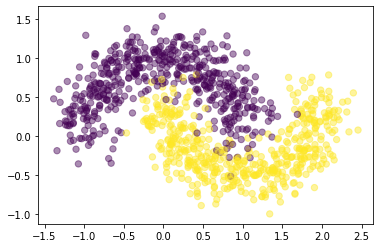

In [1]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

The number of nodes in the input layer will be determined by the dimensionality of our data (2). Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ y = \mbox{softmax}({z_2})$$

where $y$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

A common choice with the softmax output is the **cross-entropy loss**. If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [2]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength


In [4]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [5]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.579072
Loss after iteration 1000: 0.318194
Loss after iteration 2000: 0.297823
Loss after iteration 3000: 0.292968
Loss after iteration 4000: 0.289702
Loss after iteration 5000: 0.286239
Loss after iteration 6000: 0.282110
Loss after iteration 7000: 0.277041
Loss after iteration 8000: 0.270838
Loss after iteration 9000: 0.263436
Loss after iteration 10000: 0.254934
Loss after iteration 11000: 0.245598
Loss after iteration 12000: 0.235800
Loss after iteration 13000: 0.225928
Loss after iteration 14000: 0.216313
Loss after iteration 15000: 0.207199
Loss after iteration 16000: 0.198736
Loss after iteration 17000: 0.190997
Loss after iteration 18000: 0.183991
Loss after iteration 19000: 0.177694
Loss after iteration 20000: 0.172053
Loss after iteration 21000: 0.167009
Loss after iteration 22000: 0.162497
Loss after iteration 23000: 0.158456
Loss after iteration 24000: 0.154825
Loss after iteration 25000: 0.151550
Loss after iteration 26000: 0.148580
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

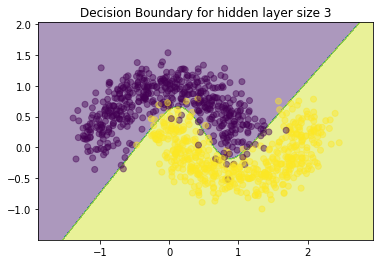

In [6]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

Add an additional layer to your neural network model. Change the activation function and use a ReLU. Does it work?


First, we're going to adapt the functions from the previous block for this problem:

In [7]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

def relu(x):
    return np.maximum(0, x)

def forward_propagation(model, X=X):
    # Get parameters from model
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return probs

# Loss
def loss(model):
    # Get parameters from model
    W1, W2, W3, = model['W1'], model['W2'], model['W3']
    
    probs = forward_propagation(model)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    
    return 1./num_examples * data_loss

# Prediction
def predict(model, X):
    probs = forward_propagation(model, X)
    
    return np.argmax(probs, axis=1)


def create_nn_2_hl(nn_input_dim, nn_hdim, print_loss=False):
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim[0]) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim[0]))
    W2 = np.random.randn(nn_hdim[0], nn_hdim[1]) / np.sqrt(nn_hdim[0])
    b2 = np.zeros((1, nn_hdim[1]))
    W3 = np.random.randn(nn_hdim[1], nn_output_dim) / np.sqrt(nn_hdim[1])
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    return model


def train_nn_2hl(model, num_passes=50000, print_loss=False):    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# DOESN'T WORK

# your code here

# Forward propagation function
def forward_propagation(model, X, activation):
    # Get parameters from model
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    #print(activation)
    a1 = activation(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = activation(z2)
    z3 = np.dot(a2, W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return probs

# Loss
def loss(model, X, y, activation, reg_lambda):
    # Get parameters from model
    W1, W2, W3, = model['W1'], model['W2'], model['W3']
    
    probs = forward_propagation(model, X, activation)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(len(X)), y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    
    return 1./num_examples * data_loss

# Prediction
def predict(model, X, activation):
    probs = forward_propagation(model, X, activation)
    
    return np.argmax(probs, axis=1)


def create_nn_2_hl(nn_input_dim, nn_hdim, print_loss=False):
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim[0]) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim[0]))
    W2 = np.random.randn(nn_hdim[0], nn_hdim[1]) / np.sqrt(nn_hdim[0])
    b2 = np.zeros((1, nn_hdim[1]))
    W3 = np.random.randn(nn_hdim[1], nn_output_dim) / np.sqrt(nn_hdim[1])
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    return model

import copy

def train_nn_2hl(X, y, _model, loss, activation, n_epochs=50, batch_size=32, theta=0.01, reg_lambda=0.01):
    model = copy.deepcopy(_model)
    
    sample_size = len(X)
    n_batches = sample_size // batch_size + 1
    # Apply SGD with minibatches
    for i in range(n_epochs):
        shuffle_indices = np.random.permutation(sample_size)
        X_shuffle = X[shuffle_indices]
        y_shuffle = y[shuffle_indices]
        
        for j in range(n_batches):
            X_batch = X_shuffle[j*batch_size:(j+1)*batch_size]
            y_batch = y_shuffle[j*batch_size:(j+1)*batch_size]
            # Forward propagation
            predict(model, X_batch, activation)
            
            # computing the derivative by AD
            gradient_loss = grad(loss)
            
            # flattening nested containers containing numpy arrays
            # Returns 1D numpy array and an unflatten function.
            
            model_flat, unflatten_m = flatten(model)
            grad_flat, unflatten_g = flatten(gradient_loss(model, X_batch, y_batch, activation, reg_lambda))
            
            # gradient descend
            model_flat -= grad_flat * theta
            model = unflatten_m(model_flat)
            #print(f'Iteration: {j}/{n_batches}', end='', flush=True)
        
        print(f'Loss at epoch {i+1}/{n_epochs}: {loss(model, X_shuffle, y_shuffle, activation, reg_lambda)}')

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        #if print_loss and i % 1000 == 0:
        #print("Loss after iteration %i: %f" %(i, loss(model, activation)))
    
    return model

# WORKS

In [8]:
nn = create_nn_2_hl(nn_input_dim, (5, 6))
print(nn)

{'W1': array([[ 1.24737338,  0.28295388,  0.69207227,  1.58455078,  1.32056292],
       [-0.69103982,  0.67181396, -0.10702571, -0.07298675,  0.29033699]]), 'b1': array([[0., 0., 0., 0., 0.]]), 'W2': array([[ 0.06441824,  0.65037088,  0.34034642,  0.05441472,  0.19850167,
         0.1492237 ],
       [ 0.66817247, -0.09174956,  0.14000813, -0.38196323, -1.14173175,
         0.29230712],
       [ 0.38658762, -0.33190629,  1.01506513, -0.6504121 ,  0.02046383,
        -0.08371116],
       [ 0.6854797 ,  0.65711722,  0.0692946 ,  0.16911942, -0.39702986,
        -0.88583911],
       [-0.15559104,  0.06992138,  0.55020272,  0.53772062, -0.17321782,
        -0.1351939 ]]), 'b2': array([[0., 0., 0., 0., 0., 0.]]), 'W3': array([[-0.42806996, -0.5797199 ],
       [-0.69658189,  0.79640072],
       [-0.20806463, -0.17884308],
       [-0.51145156,  0.31740911],
       [-0.65887104, -0.08685086],
       [-0.36557269,  0.15795228]]), 'b3': array([[0., 0.]])}


def relu(x):
    #print(x.shape)
    return np.maximum(0, x)

In [9]:
model = train_nn_2hl(nn, print_loss=True)

Loss after iteration 0: 0.678020
Loss after iteration 1000: 0.331611
Loss after iteration 2000: 0.289175
Loss after iteration 3000: 0.263719
Loss after iteration 4000: 0.245967
Loss after iteration 5000: 0.215780
Loss after iteration 6000: 0.178504
Loss after iteration 7000: 0.146751
Loss after iteration 8000: 0.126504
Loss after iteration 9000: 0.114546
Loss after iteration 10000: 0.107319
Loss after iteration 11000: 0.102935
Loss after iteration 12000: 0.100024
Loss after iteration 13000: 0.096978
Loss after iteration 14000: 0.094198
Loss after iteration 15000: 0.092239
Loss after iteration 16000: 0.090669
Loss after iteration 17000: 0.089452
Loss after iteration 18000: 0.088394
Loss after iteration 19000: 0.087425
Loss after iteration 20000: 0.086722
Loss after iteration 21000: 0.086166
Loss after iteration 22000: 0.085525
Loss after iteration 23000: 0.084984
Loss after iteration 24000: 0.084546
Loss after iteration 25000: 0.084096
Loss after iteration 26000: 0.083656
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

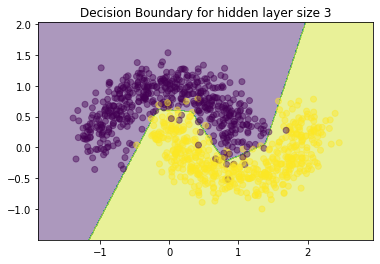

In [10]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 2

Design (change parameters) and train a NN to classify the following dataset. 


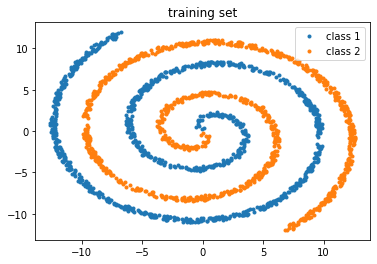

(2000, 2) (2000,)


In [3]:
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points, dtype=np.int32),np.ones(n_points, dtype=np.int32))))

X, y = twospirals(1000)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

num_examples = len(X) # training set size
print(X.shape, y.shape)

In [27]:
# your code here
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

def relu(x):
    return np.maximum(0, x)

def forward_propagation(model, X=X):
    # Get parameters from model
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = relu(z3)
    z4 = np.dot(a3, W4) + b4
    a4 = relu(z4)
    z5 = np.dot(a4, W5) + b5
    exp_scores = np.exp(z5)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return probs

# Loss
def loss(model):
    # Get parameters from model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    
    probs = forward_propagation(model)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)) + np.sum(np.square(W4)) + np.sum(np.square(W5)))
    
    return 1./num_examples * data_loss

# Prediction
def predict(model, X):
    probs = forward_propagation(model, X)
    
    return np.argmax(probs, axis=1)


def create_nn_3_hl(nn_input_dim, nn_hdim, print_loss=False):
    # Initialize the parameters to random values. 
    np.random.seed(0)
    
    W1 = np.random.randn(nn_input_dim, nn_hdim[0]) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim[0]))
    
    W2 = np.random.randn(nn_hdim[0], nn_hdim[1]) / np.sqrt(nn_hdim[0])
    b2 = np.zeros((1, nn_hdim[1]))
    
    W3 = np.random.randn(nn_hdim[1], nn_hdim[2]) / np.sqrt(nn_hdim[1])
    b3 = np.zeros((1, nn_hdim[2]))
    
    W4 = np.random.randn(nn_hdim[2], nn_hdim[3]) / np.sqrt(nn_hdim[2])
    b4 = np.zeros((1, nn_hdim[3]))
    
    W5 = np.random.randn(nn_hdim[3], nn_output_dim) / np.sqrt(nn_hdim[3])
    b5 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4, 'W5': W5, 'b5': b5}
    
    return model


def train_nn(model, num_passes=50000, print_loss=False):    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

In [28]:
nn = create_nn_3_hl(nn_input_dim, (8, 8, 8, 8))
print(nn)

{'W1': array([[ 1.24737338,  0.28295388,  0.69207227,  1.58455078,  1.32056292,
        -0.69103982,  0.67181396, -0.10702571],
       [-0.07298675,  0.29033699,  0.10185419,  1.02832666,  0.53813494,
         0.08603723,  0.3138587 ,  0.23594338]]), 'b1': array([[0., 0., 0., 0., 0., 0., 0., 0.]]), 'W2': array([[ 0.52823672, -0.0725344 ,  0.11068615, -0.30196844, -0.90261821,
         0.23108907,  0.30562435, -0.26239496],
       [ 0.80247944, -0.51419592,  0.01617808, -0.06617948,  0.54191929,
         0.51949678,  0.05478219,  0.13370064],
       [-0.31387966, -0.70031731, -0.12300552,  0.05527771,  0.43497344,
         0.42510547, -0.13694071, -0.10688016],
       [-0.37071946, -0.50205216, -0.60325761,  0.68970326, -0.18018926,
        -0.15488265, -0.44293005,  0.27488435],
       [-0.57059906, -0.07521505, -0.31659524,  0.13679069, -0.18059689,
        -0.41741651, -0.00996392,  0.15143819],
       [ 0.02351739,  0.10693997, -0.22426673, -0.12824837, -0.23775067,
        -0.12712

In [29]:
model = train_nn(nn, print_loss=True)

Loss after iteration 0: 0.673635
Loss after iteration 1000: 0.654133
Loss after iteration 2000: 0.649460
Loss after iteration 3000: 0.643367
Loss after iteration 4000: 0.639684
Loss after iteration 5000: 0.637745
Loss after iteration 6000: 0.636158
Loss after iteration 7000: 0.634477
Loss after iteration 8000: 0.632429
Loss after iteration 9000: 0.629889
Loss after iteration 10000: 0.607548
Loss after iteration 11000: 0.571492
Loss after iteration 12000: 0.539261
Loss after iteration 13000: 0.521391
Loss after iteration 14000: 0.508521
Loss after iteration 15000: 0.484007
Loss after iteration 16000: 0.460757
Loss after iteration 17000: 0.446950
Loss after iteration 18000: 0.426758
Loss after iteration 19000: 0.417879
Loss after iteration 20000: 0.403955
Loss after iteration 21000: 0.393411
Loss after iteration 22000: 0.377705
Loss after iteration 23000: 0.360862
Loss after iteration 24000: 0.340427
Loss after iteration 25000: 0.325380
Loss after iteration 26000: 0.312404
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

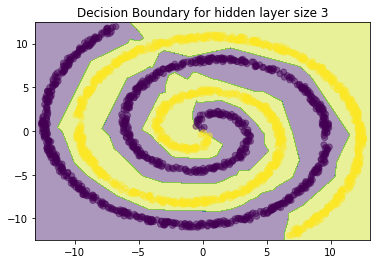

In [30]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")